In [1]:
import pandas as pd
import os
from sodapy import Socrata
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import explore
import wrangle

pd.set_option('display.max_column', None)

# Acquire and Prepare the Dta
We'll use the wrangle module to acquire and prepare the data in one step

In [2]:
df = wrangle.wrangle_crime_data()

Using cached csv


In [3]:
print(df.shape)
df.head()

(349581, 17)


,crime_type,family_violence,occurence_date,occurence_time,report_date,report_time,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared
34573,ASSAULT ON PUBLIC SERVANT,N,2021-12-31,23:50,2021-12-31,23:50,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,GE,3,30.263739,-97.743651,cleared by arrest,2022-01-03,True
34574,THEFT,N,2021-12-31,23:50,2022-01-07,14:12,OTHER / UNKNOWN,6936 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HE,5,30.215264,-97.703019,not cleared,2022-01-10,False
34575,PUBLIC INTOXICATION,N,2021-12-31,23:50,2021-12-31,23:50,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,406 E 6TH ST,78701.0,9.0,GE,2,30.267300,-97.738857,cleared by arrest,2021-12-31,True
34576,DOC DISCHARGE GUN - PUB PLACE,N,2021-12-31,23:47,2021-12-31,23:47,RESIDENCE / HOME,1202 E ST JOHNS AVE,78752.0,4.0,ID,1,30.328049,-97.693683,not cleared,2022-01-05,False
34577,AGG ASLT STRANGLE/SUFFOCATE,Y,2021-12-31,23:40,2022-01-01,00:44,RESIDENCE / HOME,10000 N LAMAR BLVD,78758.0,4.0,ED,1,30.369262,-97.695105,not cleared,2022-01-05,False


# Explore the Distributions of the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436548
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        349581 non-null  object        
 1   family_violence   349581 non-null  object        
 2   occurence_date    349581 non-null  datetime64[ns]
 3   occurence_time    349581 non-null  object        
 4   report_date       349581 non-null  datetime64[ns]
 5   report_time       349581 non-null  object        
 6   location_type     349581 non-null  object        
 7   address           349581 non-null  object        
 8   zip_code          349581 non-null  float64       
 9   council_district  349581 non-null  float64       
 10  sector            349581 non-null  object        
 11  district          349581 non-null  object        
 12  latitude          349581 non-null  float64       
 13  longitude         349581 non-null  float64       
 14  

In [5]:
# Use .describe with object columns
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')


CRIME_TYPE
Count:
BURGLARY OF VEHICLE               34886
THEFT                             29943
FAMILY DISTURBANCE                24386
CRIMINAL MISCHIEF                 19382
ASSAULT W/INJURY-FAM/DATE VIOL    12857
                                  ...  
COMMERCIAL BRIBERY                    1
ATT BURGLARY OF RESIDENCE             1
SALE OF DXM TO MINOR                  1
MANF SYNTHETIC MARIJUANA              1
BAIL JUMPING/FAIL TO APPEAR           1
Name: crime_type, Length: 341, dtype: int64


Proportions:
BURGLARY OF VEHICLE               0.099794
THEFT                             0.085654
FAMILY DISTURBANCE                0.069758
CRIMINAL MISCHIEF                 0.055444
ASSAULT W/INJURY-FAM/DATE VIOL    0.036778
                                    ...   
COMMERCIAL BRIBERY                0.000003
ATT BURGLARY OF RESIDENCE         0.000003
SALE OF DXM TO MINOR              0.000003
MANF SYNTHETIC MARIJUANA          0.000003
BAIL JUMPING/FAIL TO APPEAR       0.000003
Name: crim

In [6]:
df.council_district.value_counts()

9.0     56374
3.0     51663
4.0     48615
7.0     39888
1.0     39585
2.0     33606
5.0     28417
6.0     20494
10.0    16128
8.0     14811
Name: council_district, dtype: int64

# Split the Data for Exploratation

In [7]:
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

((195764, 17), (83900, 17), (69917, 17))

In [8]:
#Assign my .shp file to a variable named “asutin_map”
austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [9]:
austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [17]:
austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})
austin_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip_code  54 non-null     float64 
 1   geometry  54 non-null     geometry
dtypes: float64(1), geometry(1)
memory usage: 992.0 bytes


In [15]:
austin_map['zip_code'] = austin_map.zip_code.astype('float64')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436548
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        349581 non-null  object        
 1   family_violence   349581 non-null  object        
 2   occurence_date    349581 non-null  datetime64[ns]
 3   occurence_time    349581 non-null  object        
 4   report_date       349581 non-null  datetime64[ns]
 5   report_time       349581 non-null  object        
 6   location_type     349581 non-null  object        
 7   address           349581 non-null  object        
 8   zip_code          349581 non-null  float64       
 9   council_district  349581 non-null  float64       
 10  sector            349581 non-null  object        
 11  district          349581 non-null  object        
 12  latitude          349581 non-null  float64       
 13  longitude         349581 non-null  float64       
 14  

In [18]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
new_df = austin_map.merge(df, on ='zip_code')

In [21]:
new_df.to_csv('Geo_Crime_Reports.csv')

In [20]:
new_df.info()

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 349574 entries, 0 to 349573
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   zip_code          349574 non-null  float64       
 1   geometry          349574 non-null  geometry      
 2   crime_type        349574 non-null  object        
 3   family_violence   349574 non-null  object        
 4   occurence_date    349574 non-null  datetime64[ns]
 5   occurence_time    349574 non-null  object        
 6   report_date       349574 non-null  datetime64[ns]
 7   report_time       349574 non-null  object        
 8   location_type     349574 non-null  object        
 9   address           349574 non-null  object        
 10  council_district  349574 non-null  float64       
 11  sector         

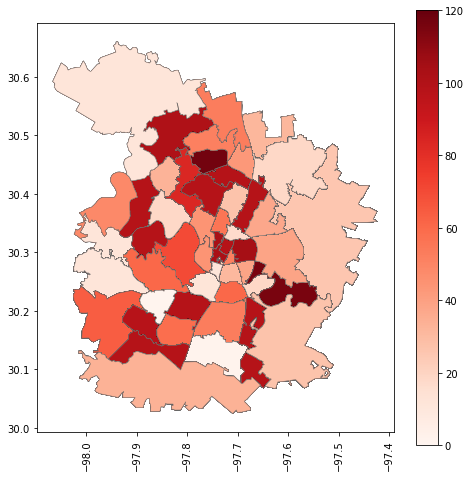

In [24]:
#Crime_type by zip_code
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=90)
new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195764 entries, 128272 to 382883
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        195764 non-null  object        
 1   family_violence   195764 non-null  object        
 2   occurence_date    195764 non-null  datetime64[ns]
 3   occurence_time    195764 non-null  object        
 4   report_date       195764 non-null  datetime64[ns]
 5   report_time       195764 non-null  object        
 6   location_type     195764 non-null  object        
 7   address           195764 non-null  object        
 8   zip_code          195764 non-null  float64       
 9   council_district  195764 non-null  float64       
 10  sector            195764 non-null  object        
 11  district          195764 non-null  object        
 12  latitude          195764 non-null  float64       
 13  longitude         195764 non-null  float64       
 14 

In [23]:
train.council_district.value_counts()

9.0     31596
3.0     28789
4.0     27418
7.0     22483
1.0     22055
2.0     18698
5.0     16014
6.0     11376
10.0     9010
8.0      8325
Name: council_district, dtype: int64

### General takeaways
- total of 195K rows of crime
- district 9 has highest count at 31k
- district 3/4 have roughly the same at 28k
- district 7/1 have 22k each of crime
- district 2/5 have about 17k
- district 6/10/8 have the lowest counts by far

#### What kind of crime is in each district?

In [25]:
train.council_district.value_counts()

9.0     31596
3.0     28789
4.0     27418
7.0     22483
1.0     22055
2.0     18698
5.0     16014
6.0     11376
10.0     9010
8.0      8325
Name: council_district, dtype: int64

In [26]:
one = train[train.council_district == 1]
two = train[train.council_district == 2]
three = train[train.council_district == 3]
four = train[train.council_district == 4]
five = train[train.council_district == 5]
six = train[train.council_district == 6]
seven = train[train.council_district == 7]
eight = train[train.council_district == 8]
nine = train[train.council_district == 9]
ten = train[train.council_district == 10]


one.shape, two.shape, three.shape, four.shape, five.shape, six.shape, seven.shape, eight.shape, nine.shape, ten.shape

((22055, 17),
 (18698, 17),
 (28789, 17),
 (27418, 17),
 (16014, 17),
 (11376, 17),
 (22483, 17),
 (8325, 17),
 (31596, 17),
 (9010, 17))

In [27]:
# district 9 has the most crime
nine.crime_type.value_counts()

THEFT                            3119
BURGLARY OF VEHICLE              2990
ASSAULT BY CONTACT               1650
CRIMINAL MISCHIEF                1643
ASSAULT WITH INJURY              1414
                                 ... 
ASSAULT - SCHOOL PERSONNEL          1
REPEAT RUNAWAY                      1
TRUANCY                             1
AGG PROMOTION OF PROSTITUTION       1
MANSLAUGHTER                        1
Name: crime_type, Length: 260, dtype: int64

In [33]:
def district_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.council_district.value_counts(ascending = True, normalize = False).plot.barh(color = 'orange',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Council District',fontsize=12)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()


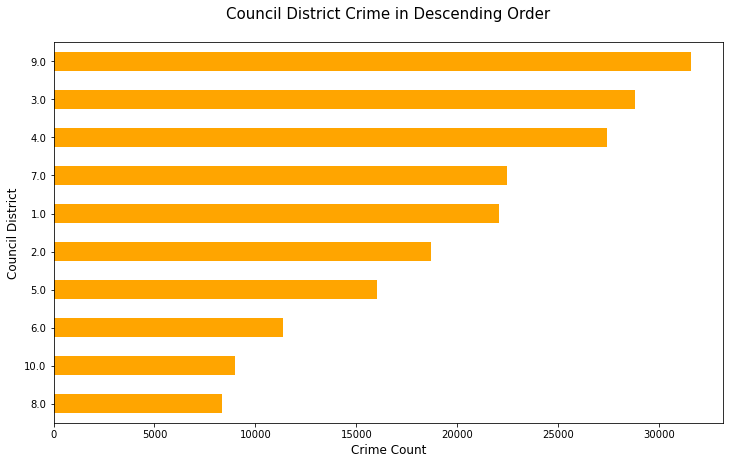

In [32]:
district_crime(train)

In [30]:
train.head()

,crime_type,family_violence,occurence_date,occurence_time,report_date,report_time,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared
128272,IDENTITY THEFT,N,2020-12-29,18:30,2020-12-30,01:46,RESIDENCE / HOME,504 ARBOR LN,78745.0,3.0,DA,3,30.210307,-97.779062,not cleared,2020-12-30,False
420369,POSS CONTROLLED SUB/NARCOTIC,N,2018-03-03,01:47,2018-03-03,01:47,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,404 E 6TH ST,78701.0,9.0,GE,2,30.267321,-97.738933,cleared by arrest,2018-05-05,True
79483,BURGLARY OF VEHICLE,N,2021-07-05,00:00,2021-07-06,19:54,RESIDENCE / HOME,2200 PANTHER TRL,78704.0,5.0,DA,4,30.237971,-97.786882,not cleared,2021-07-15,False
430217,INTERFERENCE PUBLIC DUTIES,N,2018-01-25,17:24,2018-01-31,17:24,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,2200 W SLAUGHTER LN,78748.0,5.0,FR,1,30.174079,-97.827130,cleared by arrest,2018-01-31,True
280218,BURGLARY OF VEHICLE,N,2019-07-10,18:15,2019-07-11,09:49,PARKING /DROP LOT/ GARAGE,121 PICKLE RD,78704.0,3.0,DA,2,30.227295,-97.763052,not cleared,2019-07-16,False


In [85]:
def lower_zipcode_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).tail(10).plot.barh(color = 'red',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Highest Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

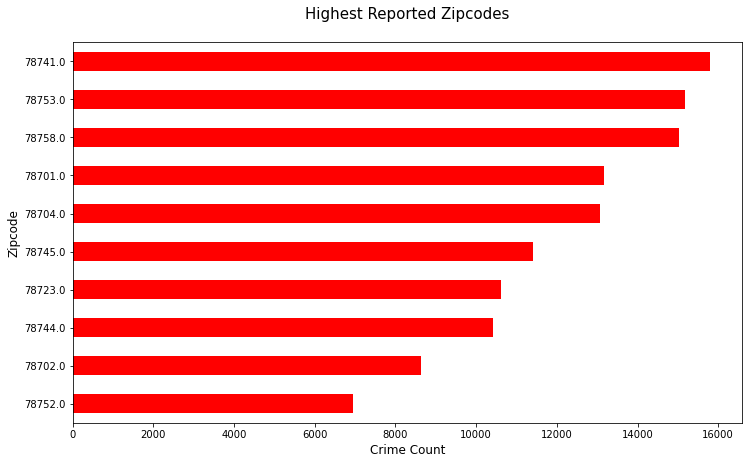

In [86]:
lower_zipcode_crime(train)

In [83]:
def upper_zipcode_crime(train):
    """
    This function is to create a visual to show top 10 safest zipcodes in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).head(10).plot.barh(color = 'green',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Least Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

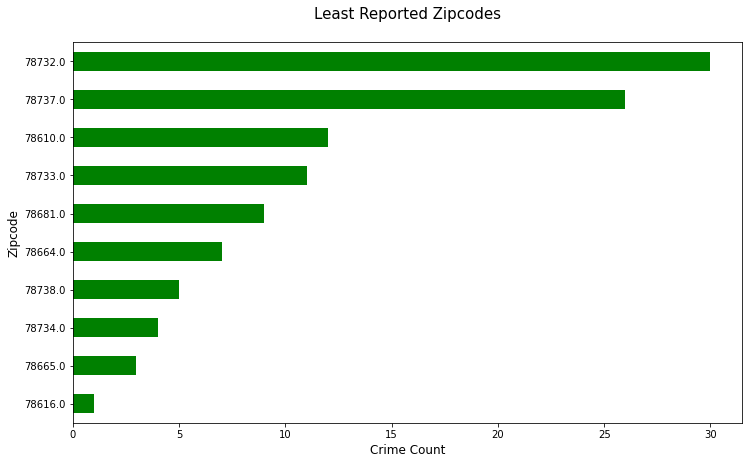

In [84]:
upper_zipcode_crime(train)

In [88]:
nine.cleared.value_counts()

False    23640
True      7956
Name: cleared, dtype: int64